# Fetching data from SpaceX REST API and Wikipedia statistics

<hr>
Author: Jesse Huang 

Date created: July 18, 2023 

Date last updated: July 20, 2023

<hr>

### Perform data collection (Part 1 and 2)
SpaceX rocket launch data are fetched from two different sources.

- SpaceX REST API (requests)
- Wikipedia Launch Data Tables (webscraping: BS4, BeautifulSoup)

Variables – (Identifier/Predictors)
- Rocket: Booster name (identifier)
- Launchpad: launch site, longitude, and latitude
- Payload: mass of the payload, the orbit
- Cores: outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, whether the core is reused, whether legs were used, the landing pad used, the block of the core, number of times this has been reused, and the serial of the core
- Outcome (T/F): whether boosters successfully landed (regardless of condition)

### Perform data wrangling (Part 3)
Raw API request data and web-scrapped tables were cleaned and processed to remove 
- NA/empty values (required measures)
- metadata, unstructured/semi-structured data
- inconsistencies in categories/values
- removed unnecessary measures

Defining variables/outcomes:
- Relevant predictor variables were defined and processed
- Outcome variable was defined as binary (T/F), success/failure


Import required libraries.

In [1]:
import requests
import pandas as pd
import numpy as np
import datetime
from bs4 import BeautifulSoup

## Part 1. Importing data from SpaceX REST API

First dataset is requested from the official SpaceX Rest API (api.spacexdata.com/v4/launches/past).

Steps: 
1. The initial request fetches all historical launch data and related variables (up to 2021).
2. Further requests fetch details of each variable, often linked to different identifiers (foreign keys). These include measures for the rocket, launchpad, payloads, and cores.

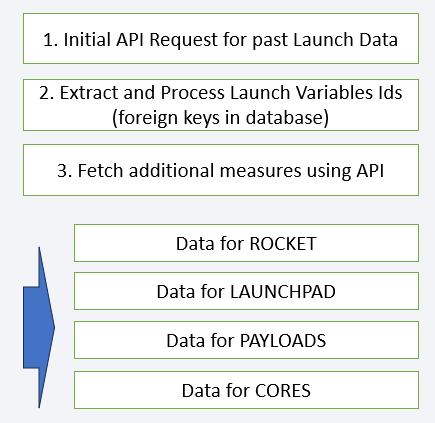

Define secondary functions for later use (for processing REST API.

In [2]:
# The auxillary functions below are provided courtesy of Joseph Santarcangelo (IBM Skills Network, 2021)
# Takes the dataset and uses the rocket column to call the API and append the data to the list
# Fetch variables: booster name
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

# Takes the dataset and uses the launchpad column to call the API and append the data to the list
# Fetch variables: launch site, longitude, and latitude
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

# Takes the dataset and uses the payloads column to call the API and append the data to the lists
# Fetch variables:  mass of the payload, the orbit
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])
        
# Takes the dataset and uses the cores column to call the API and append the data to the lists
# Fetch variables: outcome of the landing, the type of the landing, number of flights with that core, 
# whether gridfins were used, wheter the core is reused, wheter legs were used, the landing pad used, 
# the block of the core, the number of times this has been reused, and the serial of the core
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

GET Request rocket launch data from SpaceX API.

In [3]:
# {Option #1} Use Request to get root data from API
# response = requests.get("https://api.spacexdata.com/v4/launches/past")
# data = pd.json_normalized(response.json()) #Convert json to dataFrame

# {Option #2} Run locally saved version for testing
data = pd.read_json("data/API_call_spacex_api.json")

#Both options provide the same result. However, for consistency in results for comparison, we will use the local stable version.

data.head()

,fairings,links,static_fire_date_utc,static_fire_date_unix,tbd,net,window,rocket,success,details,...,failures,flight_number,name,date_utc,date_unix,date_local,date_precision,upcoming,cores,id
0,"{'reused': False, 'recovery_attempt': False, '...",{'patch': {'small': 'https://images2.imgbox.co...,2006-03-17T00:00:00.000Z,1.142554e+09,False,False,0.0,5e9d0d95eda69955f709d1eb,False,Engine failure at 33 seconds and loss of vehicle,...,"[{'time': 33, 'altitude': None, 'reason': 'mer...",1,FalconSat,2006-03-24T22:30:00.000Z,1143239400,2006-03-25T10:30:00+12:00,hour,False,"[{'core': '5e9e289df35918033d3b2623', 'flight'...",5eb87cd9ffd86e000604b32a
1,"{'reused': False, 'recovery_attempt': False, '...",{'patch': {'small': 'https://images2.imgbox.co...,None,NaN,False,False,0.0,5e9d0d95eda69955f709d1eb,False,Successful first stage burn and transition to ...,...,"[{'time': 301, 'altitude': 289, 'reason': 'har...",2,DemoSat,2007-03-21T01:10:00.000Z,1174439400,2007-03-21T13:10:00+12:00,hour,False,"[{'core': '5e9e289ef35918416a3b2624', 'flight'...",5eb87cdaffd86e000604b32b
2,"{'reused': False, 'recovery_attempt': False, '...",{'patch': {'small': 'https://images2.imgbox.co...,None,NaN,False,False,0.0,5e9d0d95eda69955f709d1eb,False,Residual stage 1 thrust led to collision betwe...,...,"[{'time': 140, 'altitude': 35, 'reason': 'resi...",3,Trailblazer,2008-08-03T03:34:00.000Z,1217734440,2008-08-03T15:34:00+12:00,hour,False,"[{'core': '5e9e289ef3591814873b2625', 'flight'...",5eb87cdbffd86e000604b32c
3,"{'reused': False, 'recovery_attempt': False, '...",{'patch': {'small': 'https://images2.imgbox.co...,2008-09-20T00:00:00.000Z,1.221869e+09,False,False,0.0,5e9d0d95eda69955f709d1eb,True,Ratsat was carried to orbit on the first succe...,...,[],4,RatSat,2008-09-28T23:15:00.000Z,1222643700,2008-09-28T11:15:00+12:00,hour,False,"[{'core': '5e9e289ef3591855dc3b2626', 'flight'...",5eb87cdbffd86e000604b32d
4,"{'reused': False, 'recovery_attempt': False, '...",{'patch': {'small': 'https://images2.imgbox.co...,None,NaN,False,False,0.0,5e9d0d95eda69955f709d1eb,True,None,...,[],5,RazakSat,2009-07-13T03:35:00.000Z,1247456100,2009-07-13T15:35:00+12:00,hour,False,"[{'core': '5e9e289ef359184f103b2627', 'flight'...",5eb87cdcffd86e000604b32e


In [4]:
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# Remove those with multiple cores and payloads
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

# Extract single value
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# Extract date information
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

In [5]:
#Global variables (place holders for fetching data)
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

In [6]:
# Call predefined functions to fetch additional data
getBoosterVersion(data)
getLaunchSite(data)
getPayloadData(data)
getCoreData(data)

In [7]:
data_falcon9 = pd.DataFrame({'FlightNumber': list(data['flight_number']),
                             'Date': list(data['date']),
                             'BoosterVersion':BoosterVersion,
                             'PayloadMass':PayloadMass,
                             'Orbit':Orbit,
                             'LaunchSite':LaunchSite,
                             'Outcome':Outcome,
                             'Flights':Flights,
                             'GridFins':GridFins,
                             'Reused':Reused,
                             'Legs':Legs,
                             'LandingPad':LandingPad,
                             'Block':Block,
                             'ReusedCount':ReusedCount,
                             'Serial':Serial,
                             'Longitude': Longitude,
                             'Latitude': Latitude})
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


Remove those using Falcon 1, keep only those with Falcon 9

In [8]:
data_falcon9_filter = data_falcon9[data_falcon9['BoosterVersion']!='Falcon 1'].copy()
data_falcon9_filter.shape

(90, 17)

Remove NAs

In [9]:
data_falcon9_filter.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [10]:
data_falcon9_filter['PayloadMass'] = data_falcon9_filter['PayloadMass'].fillna(data_falcon9_filter['PayloadMass'].mean())
data_falcon9_filter.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

Write final dataset to CSV file

In [11]:
data_falcon9_filter.to_csv('data/extract_falcon9_launch_data_API.csv', index=False)

## Part 2. Fetch Launch data from Wikipedia (webscraping)

Additional launch data were also web-scrapped from HTML tables.
https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922

Steps:
1. The webpage is first downloaded and then processed using BeautifulSoup
2. Each table (by year of launch) was extracted and converted to an dataFrame (pd).

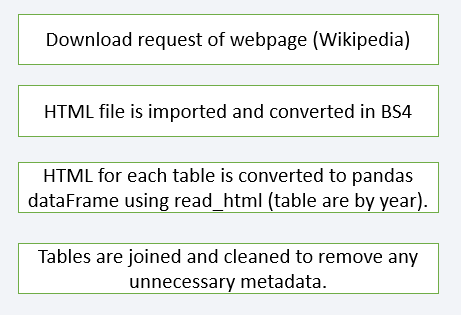

In [12]:
# {Option 1} Run this to get new version
# response = requests.get('https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922').text
# print(response.status_code)
# print(response.content)

# {Option 2} Run locally saved version for testing
request = open('data/List of Falcon 9 and Falcon Heavy launches - Wikipedia.html', encoding="utf8").read()

#Both options provide the same result. However, for consistency, we will use the local stable version.

In [13]:
soup = BeautifulSoup(request)
soup.title

<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>

In [14]:
html_tables = soup.find_all('table')
len(html_tables)
#The correct one is from 3 to 15

24

In [15]:
extract_col = ["Flight_No", "DateTime", "Version_Booster", "Launch_Site", "Payload",
              "Payload_Mass", "Orbit", "Customer", "Launch_Outcome", "Booster_Landing"]
extract_Dt = pd.read_html(str(html_tables[2]), header=0)[0]
extract_Dt.columns = extract_col
extract_Dt = extract_Dt[extract_Dt['Launch_Site']!=extract_Dt['Customer']]

for table_num in range(3,11):
    extract_new = pd.read_html(str(html_tables[table_num]), header=0)[0]
    extract_new.columns = extract_col
    extract_Dt = pd.concat([extract_Dt,extract_new[extract_new['Launch_Site']!=extract_new['Customer']]])
    
extract_Dt

,Flight_No,DateTime,Version_Booster,Launch_Site,Payload,Payload_Mass,Orbit,Customer,Launch_Outcome,Booster_Landing
0,1,"4 June 2010, 18:45",F9 v1.0[7] B0003.1[8],"CCAFS, SLC-40",Dragon Spacecraft Qualification Unit,NaN,LEO,SpaceX,Success,Failure[9][10] (parachute)
2,2,"8 December 2010, 15:43[13]",F9 v1.0[7] B0004.1[8],"CCAFS, SLC-40",Dragon demo flight C1 (Dragon C101),NaN,LEO (ISS),".mw-parser-output .plainlist ol,.mw-parser-out...",Success[9],Failure[9][14] (parachute)
4,3,"22 May 2012, 07:44[17]",F9 v1.0[7] B0005.1[8],"CCAFS, SLC-40",Dragon demo flight C2+[18] (Dragon C102),"525 kg (1,157 lb)[19]",LEO (ISS),NASA (COTS),Success[20],No attempt
6,4,"8 October 2012, 00:35[21]",F9 v1.0[7] B0006.1[8],"CCAFS, SLC-40",SpaceX CRS-1[22] (Dragon C103),"4,700 kg (10,400 lb)",LEO (ISS),NASA (CRS),Success,No attempt
7,4,"8 October 2012, 00:35[21]",F9 v1.0[7] B0006.1[8],"CCAFS, SLC-40",Orbcomm-OG2[23],172 kg (379 lb)[24],LEO,Orbcomm,Partial failure[25],No attempt
...,...,...,...,...,...,...,...,...,...,...
26,117,9 May 2021 06:42[656],F9 B5 ♺ B1051.10[657],"CCSFS, SLC-40",Starlink 27 v1.0 (60 satellites),"15,600 kg (34,400 lb)",LEO,SpaceX,Success,Success (drone ship)
28,118,15 May 2021 22:56[659],F9 B5 ♺ B1058.8[660],"KSC, LC-39A[661]",Starlink 26 v1.0 (52 Satellites) Capella-6 &T...,"~14,000 kg (31,000 lb)",LEO,SpaceX Capella Space and Tyvak,Success,Success (drone ship)
30,119,26 May 2021 18:59[664],F9 B5 ♺ B1063.2[665],"CCSFS, SLC-40[665]",Starlink 28 v1.0 (60 Satellites)[665],"15,600 kg (34,400 lb)",LEO,SpaceX,Success,Success (drone ship)
32,120,3 June 2021 17:29[667],F9 B5 B1067.1[668],"KSC, LC-39A",SpaceX CRS-22 (Dragon C209.1),"3,328 kg (7,337 lb)",LEO (ISS),NASA (CRS),Success,Success (drone ship)


In [16]:
#Clean data (remove)
extract_Dt.replace('\[.*\]','',regex=True,inplace=True)
extract_Dt.replace('\(.*\)','',regex=True,inplace=True)
extract_Dt.replace('  ',' ',regex=True,inplace=True)
extract_Dt.head()

,Flight_No,DateTime,Version_Booster,Launch_Site,Payload,Payload_Mass,Orbit,Customer,Launch_Outcome,Booster_Landing
0,1,"4 June 2010, 18:45",F9 v1.0,"CCAFS, SLC-40",Dragon Spacecraft Qualification Unit,NaN,LEO,SpaceX,Success,Failure
2,2,"8 December 2010, 15:43",F9 v1.0,"CCAFS, SLC-40",Dragon demo flight C1,NaN,LEO,".mw-parser-output .plainlist ol,.mw-parser-out...",Success,Failure
4,3,"22 May 2012, 07:44",F9 v1.0,"CCAFS, SLC-40",Dragon demo flight C2+,525 kg,LEO,NASA,Success,No attempt
6,4,"8 October 2012, 00:35",F9 v1.0,"CCAFS, SLC-40",SpaceX CRS-1,"4,700 kg",LEO,NASA,Success,No attempt
7,4,"8 October 2012, 00:35",F9 v1.0,"CCAFS, SLC-40",Orbcomm-OG2,172 kg,LEO,Orbcomm,Partial failure,No attempt


Write final dataset to CSV file

In [17]:
extract_Dt.to_csv('data/extract_falcon9_launch_data_Web.csv', index=False)

## Part 3: Data Wrangling

In [18]:
# proc_dt = pd.read_csv('data/extract_falcon9_launch_data_API.csv')
proc_dt = data_falcon9_filter.copy()
proc_dt.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,6,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,8,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,10,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,11,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,12,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


Identify the proportion of missing values in each variable

In [19]:
print(proc_dt.isnull().sum()/proc_dt.shape[0]*100)
print(proc_dt.dtypes)

FlightNumber       0.000000
Date               0.000000
BoosterVersion     0.000000
PayloadMass        0.000000
Orbit              0.000000
LaunchSite         0.000000
Outcome            0.000000
Flights            0.000000
GridFins           0.000000
Reused             0.000000
Legs               0.000000
LandingPad        28.888889
Block              0.000000
ReusedCount        0.000000
Serial             0.000000
Longitude          0.000000
Latitude           0.000000
dtype: float64
FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object


### Calculate the # launches by site

Space X launch facilities: 
- Cape Canaveral Space Launch Complex 40 VAFB SLC 4E
- Vandenberg Air Force Base Space Launch Complex 4E (SLC-4E)
- Kennedy Space Center Launch Complex 39A KSC LC 39A

In [20]:
proc_dt['LaunchSite'].value_counts()

CCSFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: LaunchSite, dtype: int64

### Calculate the # of different orbits

Most common orbits:
- LEO: Low Earth orbit (LEO)is an Earth-centred orbit with an altitude of 2,000 km (1,200 mi) or less. Most common.
- GTO: A geosynchronous orbit is a high Earth orbit that allows satellites to match Earth's rotation. Located at 22,236 miles (35,786 kilometers) above Earth's equator.
- VLEO: Very Low Earth Orbits (VLEO) can be defined as the orbits with a mean altitude below 450 km
- SSO (or SO): It is a Sun-synchronous orbit also called a heliosynchronous orbit is a nearly polar orbit around a planet

In [21]:
proc_dt['Orbit'].value_counts()

GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
ES-L1     1
HEO       1
SO        1
GEO       1
Name: Orbit, dtype: int64

### Determine Landing outcome by orbit type
The measure outcome contains two values per cell.
- True/False = whether landing was successful
- Location of landing, Ocean=Ocean RTLS=ground-pad; ASDS=drone-ship
- None is a failure to land

In [22]:
proc_dt['Outcome'].value_counts()

True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: Outcome, dtype: int64

In [23]:
proc_dt.groupby('Orbit')['Outcome'].value_counts()

Orbit  Outcome    
ES-L1  True Ocean      1
GEO    True ASDS       1
GTO    True ASDS      13
       None None      11
       False ASDS      1
       None ASDS       1
       True Ocean      1
HEO    True ASDS       1
ISS    True RTLS       7
       True ASDS       5
       None None       3
       False ASDS      2
       False Ocean     1
       False RTLS      1
       None ASDS       1
       True Ocean      1
LEO    True RTLS       4
       None None       2
       True Ocean      1
MEO    True ASDS       2
       None None       1
PO     True ASDS       5
       False ASDS      1
       False Ocean     1
       None None       1
       True Ocean      1
SO     None None       1
SSO    True RTLS       3
       True ASDS       2
VLEO   True ASDS      12
       False ASDS      2
Name: Outcome, dtype: int64

Create True/False landing outcome variable

In [24]:
proc_dt['Class'] = 1 * proc_dt['Outcome'].str.contains('True')
print(proc_dt['Class'].value_counts())
print(proc_dt["Class"].mean())

1    60
0    30
Name: Class, dtype: int64
0.6666666666666666


In [25]:
proc_dt.to_csv('data/extract_falcon9_launch_data_Main.csv', index=False)